# LEGO Complexity Analysis: Multi-Metric Scoring & Rankings

## 📖 Overview

This notebook analyzes LEGO set complexity using composite scoring algorithms and advanced SQL ranking techniques.

**Focus Areas:**
- Multi-dimensional complexity scoring
- Percentile and decile analysis
- Theme-based comparative rankings
- Outlier detection

**SQL Techniques Demonstrated:**
- CASE WHEN for conditional scoring
- NTILE for percentile grouping
- PARTITION BY for segmented rankings
- Correlated subqueries
- Statistical functions

**Prerequisites:** Database from `01_Database_Setup.ipynb`

---

## 1. Setup & Database Connection

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', None)

print("✅ Libraries imported!")

✅ Libraries imported!


In [2]:
# Connect to database
DB_NAME = '/content/lego_analysis.db'
conn = sqlite3.connect(DB_NAME)

print(f"✅ Connected to {DB_NAME}")

# Quick stats
stats = pd.read_sql("SELECT COUNT(*) as sets, MIN(year) as min_year, MAX(year) as max_year FROM sets", conn)
print(f"📦 Sets: {stats['sets'].iloc[0]:,} | Years: {stats['min_year'].iloc[0]}-{stats['max_year'].iloc[0]}")

✅ Connected to /content/lego_analysis.db
📦 Sets: 9,999 | Years: 2015-2024


---

## 2. Complexity Scoring Algorithm

### Query 1: Weighted Complexity Score

**Business Question:** How do we quantify set complexity beyond just part count?

**Scoring Formula:**
- Part count: 60% weight
- Year (recency): 20% weight
- Size category bonus: 20% weight

**SQL Techniques:**
- CASE WHEN for conditional scoring
- Weighted calculations
- NTILE for decile grouping

In [3]:
query_complexity = """
WITH set_scores AS (
    SELECT
        s.set_num,
        s.name,
        s.year,
        s.num_parts,
        t.name AS theme,
        -- Part count score (0-60 points)
        CASE
            WHEN s.num_parts >= 5000 THEN 60
            WHEN s.num_parts >= 2000 THEN 50
            WHEN s.num_parts >= 1000 THEN 40
            WHEN s.num_parts >= 500 THEN 30
            WHEN s.num_parts >= 200 THEN 20
            ELSE s.num_parts * 0.1
        END AS parts_score,
        -- Recency score (0-20 points)
        CASE
            WHEN s.year >= 2023 THEN 20
            WHEN s.year >= 2020 THEN 15
            WHEN s.year >= 2018 THEN 10
            ELSE 5
        END AS recency_score,
        -- Size category bonus (0-20 points)
        CASE
            WHEN s.num_parts >= 3000 THEN 20
            WHEN s.num_parts >= 1500 THEN 15
            WHEN s.num_parts >= 800 THEN 10
            ELSE 5
        END AS size_bonus
    FROM sets s
    LEFT JOIN themes t ON s.theme_id = t.id
    WHERE s.num_parts > 0
)
SELECT
    set_num,
    name,
    year,
    theme,
    num_parts,
    parts_score,
    recency_score,
    size_bonus,
    ROUND(parts_score + recency_score + size_bonus, 2) AS total_complexity_score,
    NTILE(10) OVER (ORDER BY (parts_score + recency_score + size_bonus) DESC) AS complexity_decile,
    RANK() OVER (ORDER BY (parts_score + recency_score + size_bonus) DESC) AS overall_rank
FROM set_scores
ORDER BY total_complexity_score DESC
LIMIT 30
"""

df_complexity = pd.read_sql(query_complexity, conn)

print("📊 Top 30 Most Complex LEGO Sets (Weighted Score)\n")
print("="*120)
display(df_complexity)

print("\n🔍 Scoring Insights:")
print(f"  • Highest score: {df_complexity['total_complexity_score'].max():.1f} points")
print(f"  • Top set: {df_complexity.iloc[0]['name']} ({df_complexity.iloc[0]['year']:.0f})")
print(f"  • Avg parts in top 10: {df_complexity.head(10)['num_parts'].mean():.0f}")

📊 Top 30 Most Complex LEGO Sets (Weighted Score)



,set_num,name,year,theme,num_parts,parts_score,recency_score,size_bonus,total_complexity_score,complexity_decile,overall_rank
0,10316-1,Lord of the Rings: Rivendell,2023,Icons,6181,60,20,20,100.0,1,1
1,71799-1,NINJAGO City Markets,2023,Ninjago,6163,60,20,20,100.0,1,1
2,75367-1,Venator-Class Republic Attack Cruiser,2023,Ultimate Collector Series,5381,60,20,20,100.0,1,1
3,76269-1,Avengers Tower,2023,Avengers,5202,60,20,20,100.0,1,1
4,10333-1,The Lord of the Rings: Barad-dûr,2024,Icons,5478,60,20,20,100.0,1,1
5,2000409-2,Window Exploration Bag,2024,Serious Play,5500,60,20,20,100.0,1,1
6,10276-1,Colosseum,2020,Icons,9036,60,15,20,95.0,1,7
7,75978-1,Diagon Alley,2020,Harry Potter,5548,60,15,20,95.0,1,7
8,10284-1,Camp Nou - FC Barcelona,2021,Icons,5509,60,15,20,95.0,1,7
9,10294-1,Titanic,2021,Icons,9092,60,15,20,95.0,1,7



🔍 Scoring Insights:
  • Highest score: 100.0 points
  • Top set: Lord of the Rings: Rivendell (2023)
  • Avg parts in top 10: 6309


### Visualization: Complexity Score Distribution

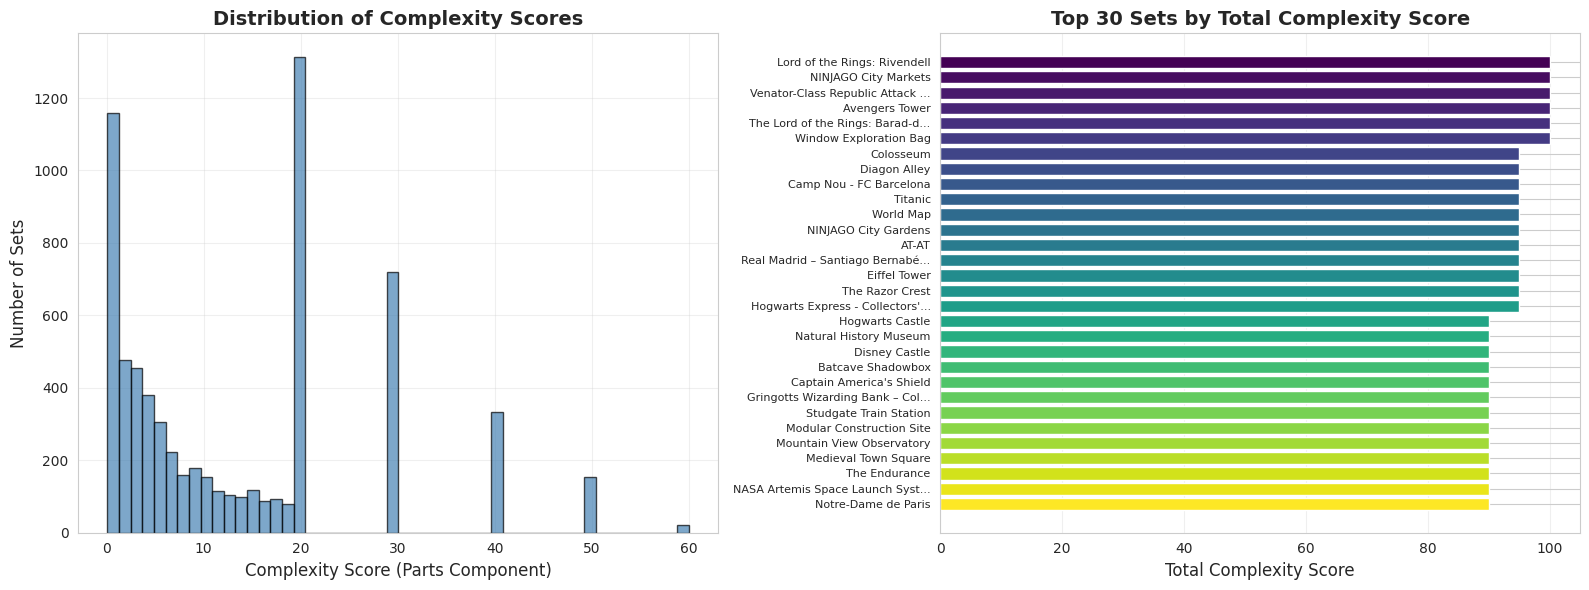

📊 Left: Overall score distribution | Right: Top 30 ranked sets


In [4]:
# Get full distribution for visualization
query_dist = """
WITH scores AS (
    SELECT
        num_parts,
        CASE
            WHEN num_parts >= 5000 THEN 60
            WHEN num_parts >= 2000 THEN 50
            WHEN num_parts >= 1000 THEN 40
            WHEN num_parts >= 500 THEN 30
            WHEN num_parts >= 200 THEN 20
            ELSE num_parts * 0.1
        END AS score
    FROM sets
    WHERE num_parts > 0
)
SELECT * FROM scores
"""
df_dist = pd.read_sql(query_dist, conn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Score distribution
ax1.hist(df_dist['score'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of Complexity Scores', fontsize=14, fontweight='bold')
ax1.set_xlabel('Complexity Score (Parts Component)', fontsize=12)
ax1.set_ylabel('Number of Sets', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Top 30 scores
top_30 = df_complexity.head(30)
colors_map = plt.cm.viridis(np.linspace(0, 1, len(top_30)))
ax2.barh(range(len(top_30)), top_30['total_complexity_score'], color=colors_map)
ax2.set_yticks(range(len(top_30)))
ax2.set_yticklabels([f"{row['name'][:30]}..." if len(row['name']) > 30 else row['name']
                      for _, row in top_30.iterrows()], fontsize=8)
ax2.invert_yaxis()
ax2.set_title('Top 30 Sets by Total Complexity Score', fontsize=14, fontweight='bold')
ax2.set_xlabel('Total Complexity Score', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("📊 Left: Overall score distribution | Right: Top 30 ranked sets")

---

## 3. Theme-Based Comparative Analysis

### Query 2: Sets Exceeding Theme Average

**Business Question:** Which sets significantly exceed their theme's average complexity?

**SQL Techniques:**
- Correlated subqueries
- Comparative analysis within groups
- Percentage calculations

In [5]:
query_theme_outliers = """
WITH theme_stats AS (
    SELECT
        theme_id,
        ROUND(AVG(num_parts), 2) AS theme_avg,
        COUNT(*) AS theme_set_count
    FROM sets
    WHERE num_parts > 0
    GROUP BY theme_id
    HAVING COUNT(*) >= 10  -- Only themes with 10+ sets
)
SELECT
    s.set_num,
    s.name,
    s.year,
    s.num_parts,
    t.name AS theme,
    ts.theme_avg,
    ts.theme_set_count,
    ROUND((s.num_parts - ts.theme_avg) * 100.0 / ts.theme_avg, 2) AS pct_above_theme_avg,
    ROUND(s.num_parts * 1.0 / ts.theme_avg, 2) AS multiplier_of_avg
FROM sets s
JOIN themes t ON s.theme_id = t.id
JOIN theme_stats ts ON s.theme_id = ts.theme_id
WHERE s.num_parts > ts.theme_avg * 2  -- At least 2x theme average
ORDER BY pct_above_theme_avg DESC
LIMIT 25
"""

df_outliers = pd.read_sql(query_theme_outliers, conn)

print("📊 Sets Significantly Exceeding Theme Average (2x+ Multiplier)\n")
print("="*120)
display(df_outliers)

print("\n🔍 Theme Outlier Insights:")
print(f"  • Biggest outlier: {df_outliers.iloc[0]['name']}")
print(f"  • Exceeds theme avg by: {df_outliers.iloc[0]['pct_above_theme_avg']:.0f}%")
print(f"  • Multiplier: {df_outliers.iloc[0]['multiplier_of_avg']:.1f}x theme average")

📊 Sets Significantly Exceeding Theme Average (2x+ Multiplier)



,set_num,name,year,num_parts,theme,theme_avg,theme_set_count,pct_above_theme_avg,multiplier_of_avg
0,71799-1,NINJAGO City Markets,2023,6163,Ninjago,290.34,393,2022.68,21.23
1,71741-1,NINJAGO City Gardens,2021,5710,Ninjago,290.34,393,1866.66,19.67
2,BIGBOX-1,The Ultimate Battle for Chima,2015,9987,Legends of Chima,644.48,23,1449.62,15.50
3,76271-1,Batman: The Animated Series Gotham City,2024,4210,Batman,284.22,86,1381.25,14.81
4,76269-1,Avengers Tower,2023,5202,Avengers,365.27,71,1324.15,14.24
5,75936-1,Jurassic Park: T. rex Rampage,2019,3120,Jurassic World,235.45,97,1225.12,13.25
6,76178-1,Daily Bugle,2021,3803,Spider-Man,287.06,69,1224.81,13.25
7,71814-1,Tournament Temple City,2024,3490,Ninjago,290.34,393,1102.04,12.02
8,9781553632832-1,Star Wars: Read Build Play - Battle for the St...,2016,196,Activity Books with LEGO Parts,16.88,175,1061.14,11.61
9,43115-1,The Boombox,2021,982,VIDIYO,95.46,37,928.70,10.29



🔍 Theme Outlier Insights:
  • Biggest outlier: NINJAGO City Markets
  • Exceeds theme avg by: 2023%
  • Multiplier: 21.2x theme average


---

## 4. Percentile & Decile Analysis

### Query 3: Part Count Percentiles by Year

**Business Question:** How does set complexity distribute across percentiles for each year?

**SQL Techniques:**
- NTILE for percentile grouping
- PARTITION BY year
- Distribution analysis

In [6]:
query_percentiles = """
WITH set_percentiles AS (
    SELECT
        year,
        set_num,
        name,
        num_parts,
        NTILE(100) OVER (PARTITION BY year ORDER BY num_parts) AS percentile,
        NTILE(10) OVER (PARTITION BY year ORDER BY num_parts) AS decile,
        NTILE(4) OVER (PARTITION BY year ORDER BY num_parts) AS quartile
    FROM sets
    WHERE num_parts > 0
)
SELECT
    year,
    COUNT(*) AS total_sets,
    -- Top percentile (90th+)
    COUNT(CASE WHEN percentile >= 90 THEN 1 END) AS top_10_pct_count,
    ROUND(AVG(CASE WHEN percentile >= 90 THEN num_parts END), 0) AS top_10_pct_avg,
    -- Top decile
    ROUND(AVG(CASE WHEN decile = 10 THEN num_parts END), 0) AS top_decile_avg,
    -- Bottom decile
    ROUND(AVG(CASE WHEN decile = 1 THEN num_parts END), 0) AS bottom_decile_avg,
    -- Top quartile
    ROUND(AVG(CASE WHEN quartile = 4 THEN num_parts END), 0) AS top_quartile_avg,
    -- Overall median approximation
    ROUND(AVG(CASE WHEN percentile BETWEEN 49 AND 51 THEN num_parts END), 0) AS median_parts
FROM set_percentiles
GROUP BY year
ORDER BY year DESC
"""

df_percentiles = pd.read_sql(query_percentiles, conn)

print("📊 Annual Part Count Distribution (Percentiles & Deciles)\n")
print("="*100)
display(df_percentiles)

print("\n🔍 Distribution Insights:")
print(f"  • 2024 top 10% average: {df_percentiles[df_percentiles['year']==2024]['top_10_pct_avg'].iloc[0]:.0f} parts")
print(f"  • 2024 median: {df_percentiles[df_percentiles['year']==2024]['median_parts'].iloc[0]:.0f} parts")
print(f"  • Gap between top/bottom deciles (2024): {df_percentiles[df_percentiles['year']==2024]['top_decile_avg'].iloc[0] - df_percentiles[df_percentiles['year']==2024]['bottom_decile_avg'].iloc[0]:.0f} parts")

📊 Annual Part Count Distribution (Percentiles & Deciles)



,year,total_sets,top_10_pct_count,top_10_pct_avg,top_decile_avg,bottom_decile_avg,top_quartile_avg,median_parts
0,2024,671,66,2112.0,2098.0,8.0,1329.0,232.0
1,2023,683,66,2263.0,2228.0,5.0,1341.0,177.0
2,2022,613,66,2127.0,2219.0,4.0,1303.0,157.0
3,2021,675,66,2241.0,2222.0,6.0,1232.0,125.0
4,2020,709,77,1648.0,1740.0,5.0,971.0,77.0
5,2019,673,66,1531.0,1520.0,4.0,907.0,92.0
6,2018,680,66,1390.0,1369.0,5.0,793.0,87.0
7,2017,643,66,1493.0,1518.0,6.0,874.0,96.0
8,2016,717,77,1229.0,1284.0,4.0,723.0,65.0
9,2015,664,66,1202.0,1202.0,4.0,703.0,73.0



🔍 Distribution Insights:
  • 2024 top 10% average: 2112 parts
  • 2024 median: 232 parts
  • Gap between top/bottom deciles (2024): 2090 parts


### Visualization: Percentile Trends

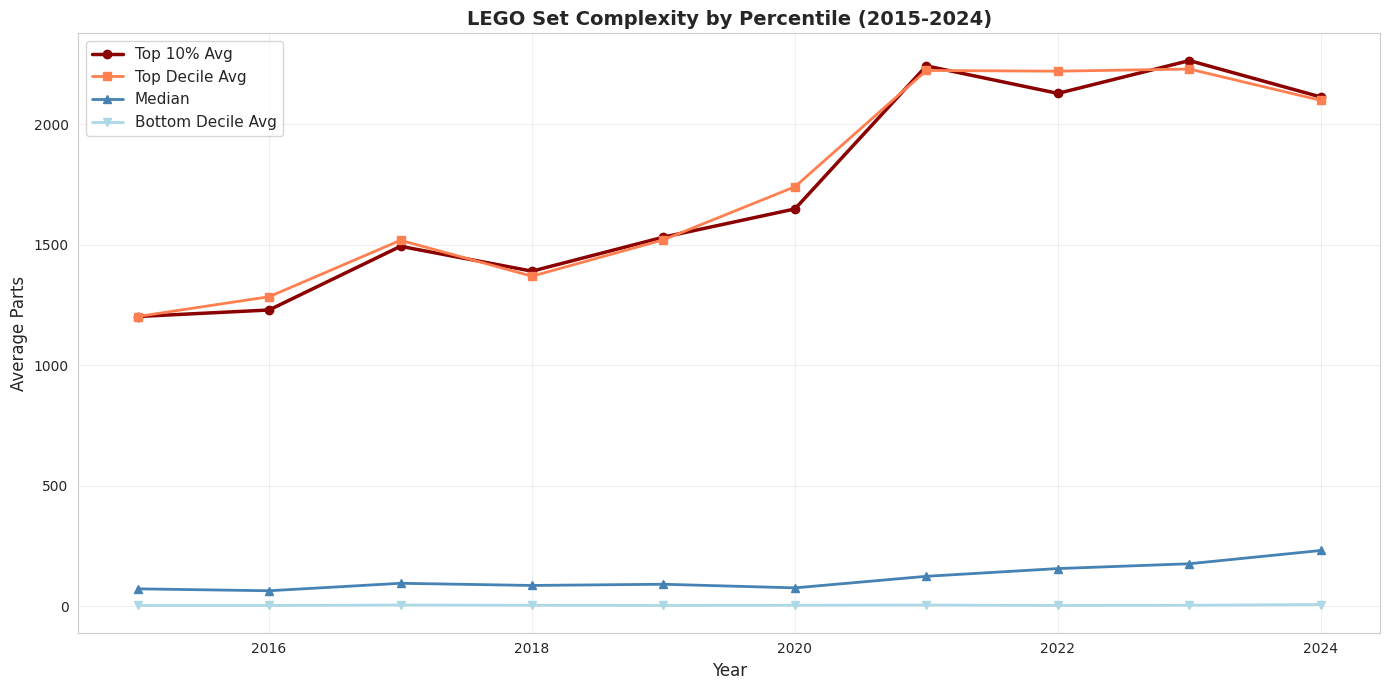

📈 Chart shows how complexity varies across different percentile groups over time


In [7]:
plt.figure(figsize=(14, 7))

# Plot different percentile levels
plt.plot(df_percentiles['year'], df_percentiles['top_10_pct_avg'],
         marker='o', linewidth=2.5, label='Top 10% Avg', color='darkred')
plt.plot(df_percentiles['year'], df_percentiles['top_decile_avg'],
         marker='s', linewidth=2, label='Top Decile Avg', color='coral')
plt.plot(df_percentiles['year'], df_percentiles['median_parts'],
         marker='^', linewidth=2, label='Median', color='steelblue')
plt.plot(df_percentiles['year'], df_percentiles['bottom_decile_avg'],
         marker='v', linewidth=2, label='Bottom Decile Avg', color='lightblue')

plt.title('LEGO Set Complexity by Percentile (2015-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Parts', fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📈 Chart shows how complexity varies across different percentile groups over time")

---

## 5. Theme Complexity Rankings

### Query 4: Theme Rankings by Average Complexity

**Business Question:** Which themes consistently produce the most/least complex sets?

**SQL Techniques:**
- Aggregation with multiple metrics
- HAVING filters
- Ranking with ties handling

In [8]:
query_theme_complexity = """
WITH theme_complexity AS (
    SELECT
        t.name AS theme,
        COUNT(s.set_num) AS set_count,
        ROUND(AVG(s.num_parts), 2) AS avg_parts,
        ROUND(MIN(s.num_parts), 0) AS min_parts,
        ROUND(MAX(s.num_parts), 0) AS max_parts,
        ROUND(SUM(s.num_parts), 0) AS total_parts,
        ROUND(MAX(s.num_parts) - MIN(s.num_parts), 0) AS range_parts
    FROM sets s
    JOIN themes t ON s.theme_id = t.id
    WHERE s.num_parts > 0
    GROUP BY t.name
    HAVING COUNT(s.set_num) >= 20  -- At least 20 sets for statistical significance
)
SELECT
    theme,
    set_count,
    avg_parts,
    min_parts,
    max_parts,
    range_parts,
    total_parts,
    RANK() OVER (ORDER BY avg_parts DESC) AS complexity_rank,
    NTILE(5) OVER (ORDER BY avg_parts DESC) AS complexity_quintile
FROM theme_complexity
ORDER BY avg_parts DESC
LIMIT 20
"""

df_theme_rank = pd.read_sql(query_theme_complexity, conn)

print("📊 Top 20 Themes by Average Complexity (20+ sets minimum)\n")
print("="*120)
display(df_theme_rank)

print("\n🔍 Theme Complexity Insights:")
print(f"  • Most complex theme: {df_theme_rank.iloc[0]['theme']} ({df_theme_rank.iloc[0]['avg_parts']:.0f} avg parts)")
print(f"  • Widest range: {df_theme_rank.loc[df_theme_rank['range_parts'].idxmax(), 'theme']} ({df_theme_rank['range_parts'].max():.0f} parts range)")
print(f"  • Most prolific complex theme: {df_theme_rank.loc[df_theme_rank['set_count'].idxmax(), 'theme']} ({df_theme_rank['set_count'].max():.0f} sets)")

📊 Top 20 Themes by Average Complexity (20+ sets minimum)



,theme,set_count,avg_parts,min_parts,max_parts,range_parts,total_parts,complexity_rank,complexity_quintile
0,Icons,48,2499.27,232.0,10001.0,9769.0,119965.0,1,1
1,LEGO Ideas and CUUSOO,64,1368.75,10.0,3955.0,3945.0,87600.0,2,1
2,Architecture,20,1132.90,147.0,4382.0,4235.0,22658.0,3,1
3,Technic,169,900.57,1.0,4108.0,4107.0,152196.0,4,1
4,FIRST LEGO League,31,861.61,12.0,2179.0,2167.0,26710.0,5,1
5,Monkie Kid,46,810.37,1.0,2371.0,2370.0,37277.0,6,1
6,Disney,47,765.13,24.0,4837.0,4813.0,35961.0,7,1
7,Harry Potter,102,748.41,26.0,6020.0,5994.0,76338.0,8,1
8,Chinese Traditional Festivals,27,661.63,4.0,1823.0,1819.0,17864.0,9,1
9,Legends of Chima,23,644.48,8.0,9987.0,9979.0,14823.0,10,1



🔍 Theme Complexity Insights:
  • Most complex theme: Icons (2499 avg parts)
  • Widest range: Legends of Chima (9979 parts range)
  • Most prolific complex theme: Technic (169 sets)


---

## 6. Key Findings & Business Insights

In [9]:
print("="*80)
print("📊 COMPLEXITY ANALYSIS - KEY FINDINGS")
print("="*80)

print("\n1️⃣ COMPLEXITY SCORING:")
print(f"   • Highest complexity score: {df_complexity['total_complexity_score'].max():.1f} points")
print(f"   • Top complex set: {df_complexity.iloc[0]['name']}")
print(f"   • Average top 10 parts: {df_complexity.head(10)['num_parts'].mean():.0f}")

print("\n2️⃣ THEME OUTLIERS:")
print(f"   • Biggest theme outlier: {df_outliers.iloc[0]['name']}")
print(f"   • Exceeds theme by: {df_outliers.iloc[0]['pct_above_theme_avg']:.0f}%")
print(f"   • Total outliers (2x+ avg): {len(df_outliers)}")

print("\n3️⃣ DISTRIBUTION PATTERNS:")
recent_year = df_percentiles['year'].max()
recent_data = df_percentiles[df_percentiles['year'] == recent_year].iloc[0]
print(f"   • {recent_year:.0f} median complexity: {recent_data['median_parts']:.0f} parts")
print(f"   • {recent_year:.0f} top 10% average: {recent_data['top_10_pct_avg']:.0f} parts")
print(f"   • Decile spread: {recent_data['top_decile_avg'] - recent_data['bottom_decile_avg']:.0f} parts")

print("\n4️⃣ THEME COMPLEXITY:")
print(f"   • Most complex theme: {df_theme_rank.iloc[0]['theme']} ({df_theme_rank.iloc[0]['avg_parts']:.0f} avg)")
print(f"   • Themes analyzed: {len(df_theme_rank)} (with 20+ sets)")
print(f"   • Avg range within themes: {df_theme_rank['range_parts'].mean():.0f} parts")

print("\n5️⃣ SQL TECHNIQUES DEMONSTRATED:")
print("   ✅ CASE WHEN conditional scoring")
print("   ✅ Weighted calculation algorithms")
print("   ✅ NTILE for percentile analysis")
print("   ✅ PARTITION BY for segmented ranking")
print("   ✅ Correlated subqueries")
print("   ✅ Statistical aggregations (min/max/avg/median)")
print("   ✅ Multi-metric comparative analysis")

print("\n" + "="*80)
print("✅ Complexity analysis complete!")
print("="*80)

📊 COMPLEXITY ANALYSIS - KEY FINDINGS

1️⃣ COMPLEXITY SCORING:
   • Highest complexity score: 100.0 points
   • Top complex set: Lord of the Rings: Rivendell
   • Average top 10 parts: 6309

2️⃣ THEME OUTLIERS:
   • Biggest theme outlier: NINJAGO City Markets
   • Exceeds theme by: 2023%
   • Total outliers (2x+ avg): 25

3️⃣ DISTRIBUTION PATTERNS:
   • 2024 median complexity: 232 parts
   • 2024 top 10% average: 2112 parts
   • Decile spread: 2090 parts

4️⃣ THEME COMPLEXITY:
   • Most complex theme: Icons (2499 avg)
   • Themes analyzed: 20 (with 20+ sets)
   • Avg range within themes: 3761 parts

5️⃣ SQL TECHNIQUES DEMONSTRATED:
   ✅ CASE WHEN conditional scoring
   ✅ Weighted calculation algorithms
   ✅ NTILE for percentile analysis
   ✅ PARTITION BY for segmented ranking
   ✅ Correlated subqueries
   ✅ Statistical aggregations (min/max/avg/median)
   ✅ Multi-metric comparative analysis

✅ Complexity analysis complete!


---

## 📋 Summary

### Analyses Performed:

1. **Weighted Complexity Scoring** - Multi-factor algorithm (parts + recency + size)
2. **Theme Comparative Analysis** - Identified sets exceeding theme benchmarks
3. **Percentile Distribution** - Year-by-year complexity distribution analysis
4. **Theme Rankings** - Ranked themes by average complexity

### Business Value:

- **Product Development:** Complexity scores guide product positioning
- **Market Segmentation:** Percentiles identify target customer sophistication
- **Competitive Analysis:** Theme outliers reveal innovation opportunities
- **Portfolio Balance:** Distribution analysis ensures diverse offerings

---

**Version:** 1.0  
**Author:** Rodion Barskov  
**Date:** January 2025  
**Focus:** Complexity Scoring & Multi-Metric Analysis